In [1]:
# Preamble
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, brier_score_loss

from utils import load_probs

In [2]:
df_raw = pd.read_pickle('results.pkl')
actual = df_raw.actual.copy()
preds = df_raw.xs('Prediction', level='Method', axis=1)
probs = df_raw.xs('Probability', level='Method', axis=1)
probs.head()

Classifier,LogisticRegression,GaussianNB,LinearSVC,RandomForestClassifier,SGDClassifier,KNeighborsClassifier
0,0.979908,1.0,0.627873,1.0,0.626272,1.0
1,0.968832,1.0,0.574250,1.0,0.631219,1.0
2,0.972728,1.0,0.578030,1.0,0.629980,1.0
3,0.999986,1.0,0.775335,1.0,0.747994,1.0
4,0.815760,1.0,0.574944,1.0,0.549328,1.0


In [3]:
# Brier Score Losses & sort Probs by brier score loss
conf_mats = np.array([confusion_matrix(actual, p).ravel()
                      for _, p in preds.iteritems()])
confusion = pd.DataFrame(conf_mats, 
                         index=preds.columns, 
                         columns=('TN', 'FP', 'FN', 'TP'))
brier_score = probs.apply(lambda v: brier_score_loss(actual, v))
confusion = confusion.assign(brier_score=brier_score)
confusion.sort_values(by='brier_score', inplace=True)
print(confusion)

probs = probs.reindex(confusion.index, axis=1)

                          TN    FP   FN    TP  brier_score
Classifier                                                
KNeighborsClassifier    5027    47  101  4825     0.012256
RandomForestClassifier  4962   112  181  4745     0.030084
LogisticRegression      4554   520  485  4441     0.074896
SGDClassifier           4671   403  990  3936     0.174904
LinearSVC               4229   845  612  4314     0.194744
GaussianNB              3801  1273  723  4203     0.195931


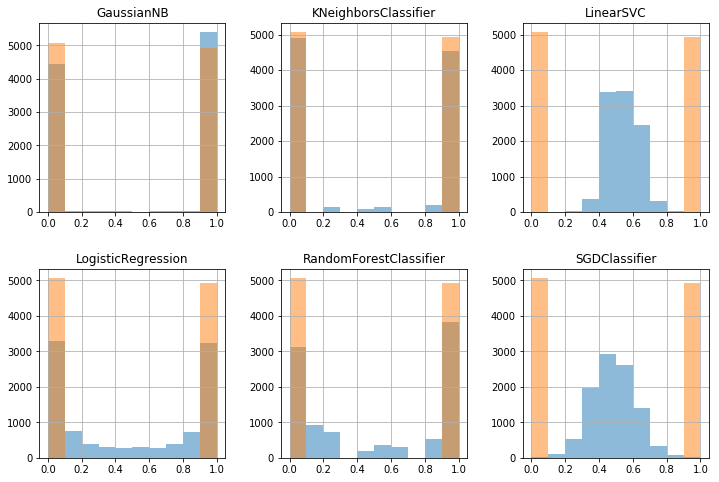

In [4]:
axes = probs.hist(figsize=(12,8), layout=(2,3), alpha=0.5)
for ax in axes.ravel():
    actual.hist(ax=ax, alpha=0.5)
plt.show()

In [5]:
probs.apply(lambda x: len(np.unique(x)))

Classifier
KNeighborsClassifier          6
RandomForestClassifier       11
LogisticRegression        10000
SGDClassifier             10000
LinearSVC                 10000
GaussianNB                 4185
dtype: int64

In [6]:
def gen_datagram(prob, actual, bins=100):
    width = bins + 1
    bins, step = np.linspace(0., 1., width, retstep=True)
    idx = np.digitize(prob, bins) - 1
    top = np.bincount(idx, weights=actual, minlength=width)
    bot = np.bincount(idx, weights=(~actual), minlength=width)
    return top, bot, bins, step

In [7]:
def draw_datagram(prob, actual, bins=100, ax=None):
    top, bot, bins, bin_width = gen_datagram(prob, actual, bins=bins)
    if ax is None:
        fig = plt.gcf()
        ax = fig.add_subplot(111)
    ax.axhline(linestyle='dashed', color='black', alpha=0.2)
    ax.axvline(x=0.5, linestyle='dashed', color='black', alpha=0.2)
    ax.bar(bins, top, width=bin_width)
    ax.bar(bins, -bot, width=bin_width)
    height = max(abs(x) for x in ax.get_ylim())
    ax.set_ylim([-height, height])
    return ax

In [8]:
vec = confusion.loc['LinearSVC']
*m, brier = vec
m, brier

([4229.0, 845.0, 612.0, 4314.0], 0.19474414125009262)

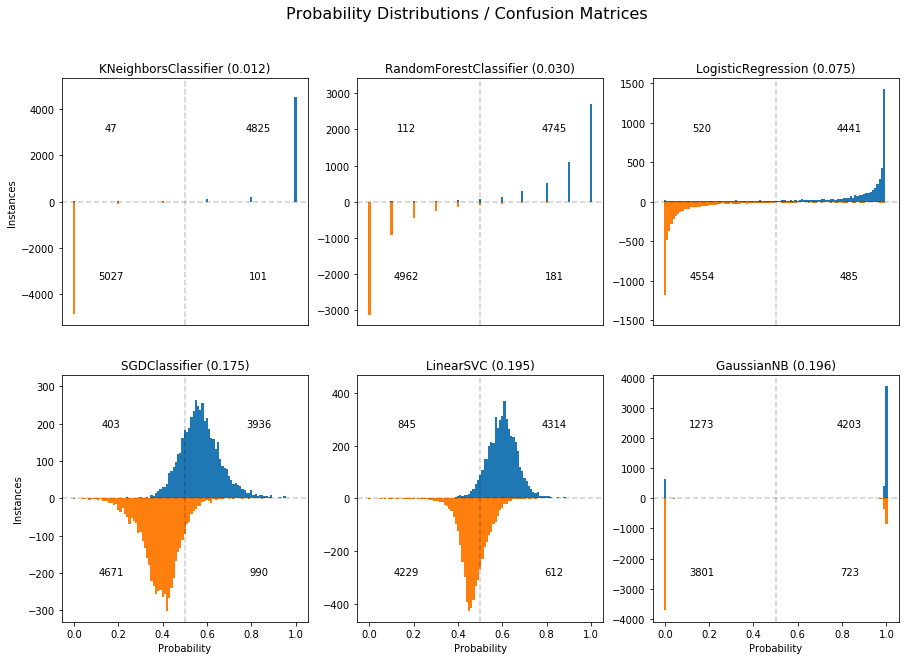

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15, 10))
axes = tuple(axes.flat)

coords = ((0.2, 0.2),
          (0.2, 0.8),
          (0.8, 0.2),
          (0.8, 0.8))

for ax, (label, prob) in zip(axes, probs.iteritems()):
    *cm, brier = confusion.loc[label]
    draw_datagram(prob.copy(), actual, ax=ax)
    for val, (x, y) in zip(cm, coords):
        ax.text(x, y, int(val), 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=ax.transAxes)
    ax.set_title(f'{label} ({brier:.3f})')

fig.suptitle('Probability Distributions / Confusion Matrices', fontsize=16)
axes[0].set_ylabel('Instances')
axes[3].set_ylabel('Instances')

for x in (0, 1, 2):
    axes[x].xaxis.set_ticks_position('none')
axes[3].set_xlabel('Probability')
axes[4].set_xlabel('Probability')
axes[5].set_xlabel('Probability')

# plt.tight_layout()
plt.show()

### Randomness

In [10]:
# _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

# discrete = np.random.randint(2, size=10_000)
# uniform = np.random.uniform(size=10_000)

# draw_datagram(discrete, actual, ax=ax1)
# draw_datagram(uniform, actual, ax=ax2)

# plt.show()

# for i, (label, data) in enumerate(probs.iteritems()):
#     plt.figure(i, figsize=(15,15))
#     draw_datagram(data, actual)
#     plt.title(label)
#     plt.show()